In [1]:

import sys
from pathlib import Path

# Add parent directory (src/) to sys.path
sys.path.append(str(Path.cwd().parent))

from Data_Handler import get_data
import json
import os
import zipfile
from collections import Counter
from typing import Dict
import shutil
import sqlite3, json, os
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from timeit import default_timer as timer
from tqdm.auto import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassAccuracy
import optuna
import torch.optim as optim
import torch.nn.functional as F

/home/fillies/Documents/moon/kilter/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
grades = [
    "4c", "5a", "5b", "5c",
    "6a", "6a+", "6b", "6b+", "6c", "6c+",
    "7a", "7a+", "7b", "7b+", "7c", "7c+",
    "8a", "8a+", "8b", "8b+", "8c"
]


In [3]:
# loading in a specific board
data = get_data(board_name="12 x 12 with kickboard Square")
placements = data["placements"]
roles = data["roles"]

placements.describe(), roles.describe()



(            route_id     difficulty        hold_id      token_num  \
 count  452057.000000  452057.000000  452057.000000  452057.000000   
 mean   106045.795484    1242.255280     265.403715    1304.119410   
 std     65642.474089       4.485806     130.137169     130.992049   
 min         2.000000    1233.000000       3.000000    1073.000000   
 25%     47390.000000    1239.000000     176.000000    1199.000000   
 50%    105517.000000    1243.000000     277.000000    1287.000000   
 75%    162363.000000    1246.000000     363.000000    1389.000000   
 max    222622.000000    1253.000000     526.000000    1599.000000   
 
                    x              y         set_id  
 count  452057.000000  452057.000000  452057.000000  
 mean       72.420106      78.156463       5.165099  
 std        31.705649      43.410323       7.860596  
 min         4.000000       4.000000       1.000000  
 25%        48.000000      44.000000       1.000000  
 50%        72.000000      80.000000       1

In [4]:
cols = placements.groupby("x")["y"].nunique().max().item()
rows = placements.groupby("y")["x"].nunique().max().item()

cols, rows

(19, 18)

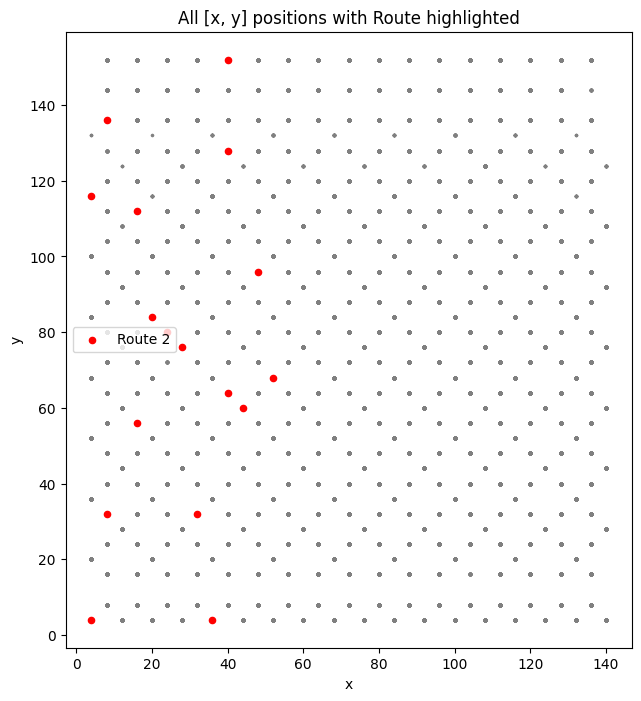

In [5]:
rid = 2
route_data = placements[placements["route_id"] == rid]


plt.figure(figsize=(8, 8))

# background: all placements (gray)
plt.scatter(placements["x"], placements["y"], s=2, alpha=0.3, color="gray")

# highlight chosen route (red)
plt.scatter(route_data["x"], route_data["y"], s=20, color="red", label=f"Route {rid}")

plt.xlabel("x")
plt.ylabel("y")
plt.title("All [x, y] positions with Route highlighted")
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

In [6]:
unique_x = sorted(placements["x"].unique())
unique_y = sorted(placements["y"].unique())
print(unique_x, unique_y)

x_map = {val: idx for idx, val in enumerate(unique_x)}
y_map = {val: idx for idx, val in enumerate(unique_y)}

placements_mapped = placements.copy()
placements_mapped["x_mapped"] = placements_mapped["x"].map(x_map)
placements_mapped["y_mapped"] = placements_mapped["y"].map(y_map)

placements_mapped.head()


[np.float64(4.0), np.float64(8.0), np.float64(12.0), np.float64(16.0), np.float64(20.0), np.float64(24.0), np.float64(28.0), np.float64(32.0), np.float64(36.0), np.float64(40.0), np.float64(44.0), np.float64(48.0), np.float64(52.0), np.float64(56.0), np.float64(60.0), np.float64(64.0), np.float64(68.0), np.float64(72.0), np.float64(76.0), np.float64(80.0), np.float64(84.0), np.float64(88.0), np.float64(92.0), np.float64(96.0), np.float64(100.0), np.float64(104.0), np.float64(108.0), np.float64(112.0), np.float64(116.0), np.float64(120.0), np.float64(124.0), np.float64(128.0), np.float64(132.0), np.float64(136.0), np.float64(140.0)] [np.float64(4.0), np.float64(8.0), np.float64(16.0), np.float64(20.0), np.float64(24.0), np.float64(28.0), np.float64(32.0), np.float64(36.0), np.float64(40.0), np.float64(44.0), np.float64(48.0), np.float64(52.0), np.float64(56.0), np.float64(60.0), np.float64(64.0), np.float64(68.0), np.float64(72.0), np.float64(76.0), np.float64(80.0), np.float64(84.0), n

,route_id,difficulty,hold_id,hold_token,token_num,token_type,x,y,set_id,role_name,role_color,x_mapped,y_mapped
0,2,1239,42,p1124,1124,placement,8.0,32.0,1.0,None,None,1,6
1,2,1239,156,p1127,1127,placement,32.0,32.0,1.0,None,None,7,6
2,2,1239,94,p1176,1176,placement,16.0,56.0,1.0,None,None,3,12
3,2,1239,169,p1196,1196,placement,40.0,64.0,1.0,None,None,9,14
4,2,1239,115,p1228,1228,placement,24.0,80.0,1.0,None,None,5,18


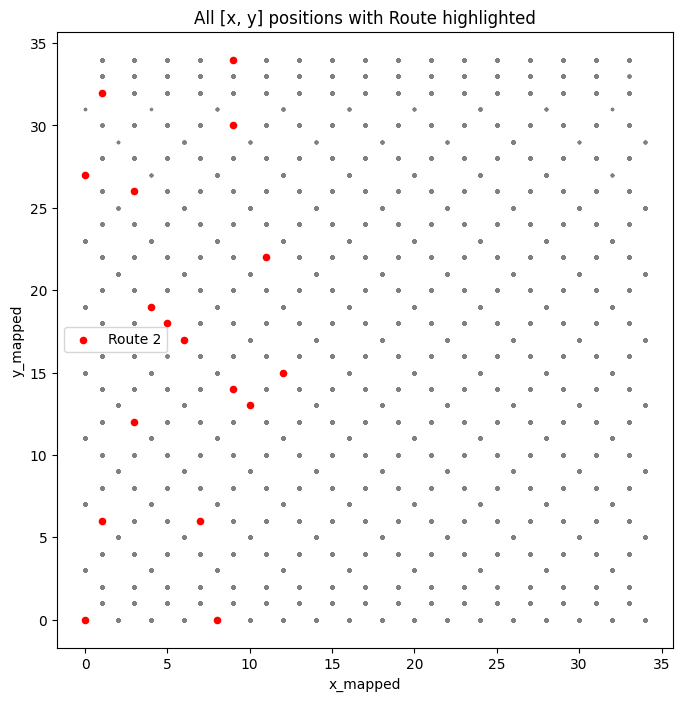

In [7]:

route_data = placements_mapped[placements["route_id"] == rid]


plt.figure(figsize=(8, 8))

# background: all placements (gray)
plt.scatter(placements_mapped["x_mapped"], placements_mapped["y_mapped"], s=2, alpha=0.3, color="gray")

# highlight chosen route (red)
plt.scatter(route_data["x_mapped"], route_data["y_mapped"], s=20, color="red", label=f"Route {rid}")

plt.xlabel("x_mapped")
plt.ylabel("y_mapped")
plt.title("All [x, y] positions with Route highlighted")
plt.gca().set_aspect("equal")
plt.legend()
plt.show()


In [8]:
route_ids = torch.tensor(placements_mapped["route_id"].values)
x = torch.tensor(placements_mapped["x_mapped"].values)
y = torch.tensor(placements_mapped["y_mapped"].values)
difficulty = torch.tensor(placements_mapped["difficulty"].values)

unique_routes, route_idx = torch.unique(route_ids, return_inverse=True)

num_routes = unique_routes.shape[0]
x_max = int(x.max().item()) + 1
y_max = int(y.max().item()) + 1


In [9]:
# shape: (N, 3)
indices = torch.stack([route_idx, x, y], dim=1)

# create one-hot channel
placement_channel = torch.zeros((num_routes, x_max, y_max), dtype=torch.float32)
placement_channel[indices[:,0], indices[:,1], indices[:,2]] = 1.0


tensor = torch.zeros((num_routes, x_max, y_max), dtype=torch.float32)
tensor[indices[:,0], indices[:,1], indices[:,2]] = 1.0

X = tensor.permute(0, 2, 1)  # -> [N, W, H]

print("Final tensor shape:", X.shape)



Final tensor shape: torch.Size([36479, 35, 35])


In [10]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# one difficulty per route
y = placements_mapped.groupby("route_id")["difficulty"].first().to_frame()

# one-hot encode
enc = OneHotEncoder(sparse_output=False)
y_encoded = enc.fit_transform(y)

# make DataFrame with route_id as index
y = pd.DataFrame(
    y_encoded,
    columns=[f"difficulty_{cls}" for cls in enc.categories_[0]],
    index=y.index  # use route_id index, not placements_mapped.index
)

print(y.shape)   # (num_routes, num_classes)
print(y)


(36479, 21)
          difficulty_1233  difficulty_1234  difficulty_1235  difficulty_1236  \
route_id                                                                       
2                     0.0              0.0              0.0              0.0   
5                     0.0              0.0              0.0              0.0   
10                    0.0              0.0              0.0              0.0   
13                    0.0              0.0              0.0              0.0   
16                    0.0              0.0              0.0              0.0   
...                   ...              ...              ...              ...   
222597                0.0              1.0              0.0              0.0   
222600                0.0              0.0              0.0              0.0   
222614                0.0              0.0              0.0              0.0   
222618                0.0              0.0              0.0              0.0   
222622                0.0   

# Model stuff

In [11]:
from utils import EarlyStopping, plot_training_history
from models import *
from trainer import train_model



torch.__version__
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X.unsqueeze(1),
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42)

X_train = X_train.to(device)
X_test  = X_test.to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test.values, dtype=torch.float32).to(device)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)


train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([64, 1, 35, 35]), torch.Size([64, 21]))

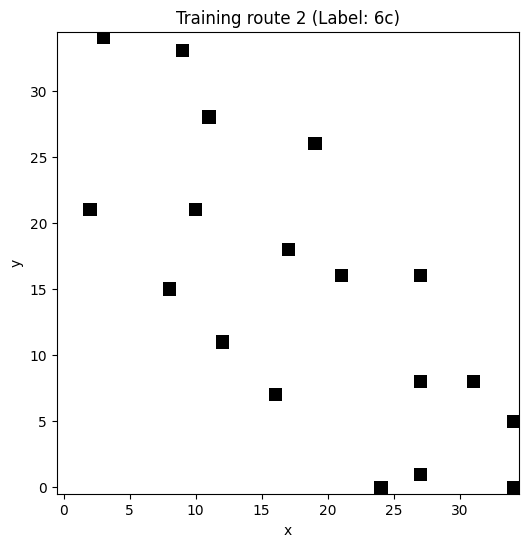

In [13]:
def plot_route(route_tensor, label_idx=None, title="Route"):
    """
    route_tensor: torch.Tensor of shape [C, H, W] or [C, H]
    label_idx: int (difficulty class index 0–20)
    """
    if route_tensor.dim() == 4:  # [1, C, H, W]
        route_tensor = route_tensor.squeeze(0)

    if route_tensor.dim() == 3:  # [C, H, W]
        board = route_tensor[0].cpu().numpy()
    elif route_tensor.dim() == 2:  # [C, H]
        board = route_tensor.cpu().numpy()
    else:
        raise ValueError(f"Unexpected shape {route_tensor.shape}")

    plt.figure(figsize=(6, 6))
    plt.imshow(board, origin="lower", cmap="Greys", interpolation="nearest")

    if label_idx is not None:
        grade = grades[label_idx] if label_idx < len(grades) else f"class {label_idx}"
        plt.title(f"{title} (Label: {grade})")
    else:
        plt.title(title)

    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()



# example usage
num = 0
route = X_train[num]          # shape [C, H, W]
label_idx = y_train[num].argmax().item()  # one-hot → class index

plot_route(route, label_idx=label_idx, title="Training route 2")


In [14]:

class_names = (y.shape[1])

### Moddel

In [ ]:
class dialationCNN(nn.Module):
        def __init__(self,
                input_shape: int,
                hidden_units_CNN: int,
                hidden_units_classifier: int,
                output_shape: int,
                drop_out: int = 0.01
                ):
                super().__init__()
                self.conv_block_1 = nn.Sequential(
                        nn.Conv2d(input_shape, hidden_units_CNN, kernel_size=3, padding=1, dilation=1), nn.ReLU(), nn.BatchNorm2d(hidden_units_CNN),
                        nn.Conv2d(hidden_units_CNN, hidden_units_CNN, kernel_size=3, padding=1, dilation=1), nn.ReLU(), nn.BatchNorm2d(hidden_units_CNN),
                        #nn.Conv2d(hidden_units_CNN, hidden_units_CNN*2, kernel_size=5, padding=2, dilation=1), nn.ReLU(), nn.BatchNorm2d(hidden_units_CNN*2),
                        #nn.Conv2d(hidden_units_CNN*2, hidden_units_CNN*3, kernel_size=3, padding=3, dilation=1), nn.ReLU(), nn.BatchNorm2d(hidden_units_CNN*3)
                )


                self.classifier = nn.Sequential(
                        nn.AdaptiveAvgPool2d(1),
                        nn.Flatten(),
                        nn.LazyLinear(out_features=hidden_units_classifier),
                        nn.ReLU(),
                        nn.Dropout(drop_out),
                        nn.Linear(hidden_units_classifier, hidden_units_classifier),
                        nn.ReLU(),
                        nn.Dropout(drop_out),
                        nn.Linear(hidden_units_classifier, output_shape)
                )
        def forward(self, x):
                #print(x.shape)
                x = self.conv_block_1(x)

                x = self.classifier(x)
                return x

model_dilation =dialationCNN(input_shape=1,
        hidden_units_CNN=16,
        hidden_units_classifier=64,
        output_shape=(class_names),
        drop_out=0.05
        ).to(device)       
model_dilation



dialationCNN(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
    (7): ReLU()
    (8): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=1)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): LazyLinear(in_features=0, out_features=64, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.05, inplace=False)
    (5): Linear(in_features=64, out_features=64, bias=True)
    (6): ReLU()
    (7): Dropout(p=0.05, inplace=False)
    (8): Linear(in_features=64, out_features=21, bias=True)
  )
)

In [29]:
print(train_features_batch.shape)
class_names = (y.shape[1])

model_0 =shallowCNN(input_shape=1,
                            hidden_units_CNN=16,
                            hidden_units_classifier=264,
                            output_shape=(class_names),
                            drop_out=0.05
                            ).to(device)

torch.Size([64, 1, 35, 35])


In [30]:
eg_route = X_train[0]
eg_route = eg_route.unsqueeze(dim=0) # unsquezze again bc so batch
#print(train_features_batch.shape)
#print(eg_route.shape)

print(model_0(eg_route).shape)


torch.Size([1, 21])


In [31]:
loss_fn = torch.nn.BCEWithLogitsLoss()
acc_fn = MulticlassAccuracy(num_classes=21).to(device)
optimizer = optim.Adam(model_0.parameters(), lr=1e-4, weight_decay=1e-5 )




In [32]:
from torch.optim import Optimizer
from torch.nn.modules.loss import _Loss
from torchmetrics import Metric
import shutil
from typing import Tuple, Dict, List

def train_model_local(
    model: torch.nn.Module,
    train_loader: DataLoader,
    test_loader: DataLoader,
    loss_fn: _Loss,
    optimizer: Optimizer,
    acc_fn: Metric,
    device: torch.device,
    epochs: int = 1000,
    patience: int = 5,
    checkpoint_path: str = "checkpoints/best_model.pt"
) -> Tuple[torch.nn.Module, Dict[str, List[float]]]:
    """
    Train a PyTorch model with early stopping.

    Args:
        model: The PyTorch model to train.
        train_loader: DataLoader for training data.
        test_loader: DataLoader for test/validation data.
        loss_fn: Loss function (e.g. nn.CrossEntropyLoss).
        optimizer: Optimizer (e.g. torch.optim.Adam).
        acc_fn: Accuracy function/metric (e.g. MulticlassAccuracy).
        device: Device to train on (torch.device('cpu') or torch.device('cuda')).
        epochs: Maximum number of epochs to train.
        patience: Patience for early stopping.
        checkpoint_path: File path to save the best model.

    Returns:
        model: The trained model loaded with best weights.
        history: Dict with training/test loss and accuracy:
            {
                "train_loss": [...],
                "train_acc": [...],
                "test_loss": [...],
                "test_acc": [...]
            }
    """
    model = model.to(device)
    early_stopping = EarlyStopping(patience=patience, path=checkpoint_path)

    all_train_loss, all_train_acc = [], []
    all_test_loss, all_test_acc = [], []


    for epoch in tqdm(range(epochs)):
        # --- training ---
        model.train()
        
        train_loss, train_acc = 0.0, 0.0

        for X, y in train_loader:
            acc_fn.reset()
            X, y = X.to(device), y.to(device)
            
            #print(X.shape, y.shape)

            y_pred = model(X)
            
            
            loss = loss_fn(y_pred, y)

            acc = acc_fn(torch.argmax(y_pred, dim=1),
                        torch.argmax(y, dim=1)).item()

            train_loss += loss.item()
            train_acc += acc

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        all_train_loss.append(train_loss)
        all_train_acc.append(train_acc)

        # --- evaluation ---
        model.eval()
        test_loss, test_acc = 0.0, 0.0
        with torch.inference_mode():
            for X_test, y_test in test_loader:
                acc_fn.reset()
                X_test, y_test = X_test.to(device), y_test.to(device)
                test_pred = model(X_test)

                test_loss += loss_fn(test_pred, y_test).item()
                test_acc += acc_fn(torch.argmax(test_pred, dim=1),
                                torch.argmax(y_test, dim=1)).item()

        test_loss /= len(test_loader)
        test_acc /= len(test_loader)

        all_test_loss.append(test_loss)
        all_test_acc.append(test_acc)

        if epoch % 1 == 0:
            print(f"\nEpoch {epoch:04d} | "
                    f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f} | "
                    f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}")

        # --- early stopping ---
        if early_stopping(test_loss, model):
            print(f"Early stopping at epoch {epoch}")
            print(f"Epoch {epoch:04d} | "
                    f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f} | "
                    f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}")
            break

    # 1. Move "best_model.pt" to checkpoint
    #shutil.copy("best_model.pt", checkpoint_path)


    history = {
        "train_loss": all_train_loss,
        "train_acc": all_train_acc,
        "test_loss": all_test_loss,
        "test_acc": all_test_acc
    }

    return model, history


In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GlobalAttentionPool(nn.Module):
    def __init__(self, in_ch):
        super().__init__()
        self.score = nn.Conv2d(in_ch, 1, kernel_size=1)

    def forward(self, x):                             # [B,C,H,W]
        s = self.score(x)                             # [B,1,H,W]
        a = torch.softmax(s.flatten(2), dim=-1)       # [B,1,HW]
        xf = x.flatten(2)                             # [B,C,HW]
        z = torch.bmm(a, xf.transpose(1,2))           # [B,1,C]
        return z.squeeze(1)                           # [B,C]

class DilationCNN(nn.Module):
    def __init__(self, in_ch, base_ch, mlp_hidden, num_classes, dropout=0.05, use_attention_pool=True):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_ch, base_ch, 3, padding=1, dilation=1, bias=False),
            nn.BatchNorm2d(base_ch),
            nn.ReLU()  # no inplace
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(base_ch, base_ch*2, 3, padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(base_ch*2),
            nn.ReLU(),
            nn.Conv2d(base_ch*2, base_ch*2, 3, padding=2, dilation=2, bias=False),
            nn.BatchNorm2d(base_ch*2),
        )
        self.short2 = nn.Conv2d(base_ch, base_ch*2, 1, bias=False)

        self.block3 = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(base_ch*2, base_ch*3, 3, padding=3, dilation=3, bias=False),
            nn.BatchNorm2d(base_ch*3),
            nn.ReLU(),
            nn.Conv2d(base_ch*3, base_ch*3, 3, padding=3, dilation=3, bias=False),
            nn.BatchNorm2d(base_ch*3),
        )
        self.short3 = nn.Conv2d(base_ch*2, base_ch*3, 1, bias=False)

        self.mix = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(base_ch*3, base_ch*3, 1, bias=False),
            nn.BatchNorm2d(base_ch*3),
            nn.ReLU(),
        )

        self.pool = GlobalAttentionPool(base_ch*3) if use_attention_pool else nn.AdaptiveAvgPool2d(1)

        feat_dim = base_ch*3
        self.classifier = nn.Sequential(
            nn.Linear(feat_dim, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        y = self.block2(x); x = self.short2(x); x = F.relu(y + x)        # no inplace
        y = self.block3(x); x = self.short3(x); x = F.relu(y + x)        # no inplace
        x = self.mix(x)
        x = self.pool(x) if isinstance(self.pool, GlobalAttentionPool) else self.pool(x).squeeze(-1).squeeze(-1)
        return self.classifier(x)

model = DilationCNN(
    in_ch=1,          # or 3 if you add CoordConv x,y channels
    base_ch=16,       # = your hidden_units_CNN
    mlp_hidden=256,   # your preferred classifier width
    num_classes=class_names,
    dropout=0.05,
    use_attention_pool=True
).to(device)

In [ ]:
model, history = train_model_local(
    model=model_dilation,
    train_loader=train_loader,
    test_loader=test_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    acc_fn=acc_fn,
    device=device,
    epochs=10,
    patience=3
)




 10%|█         | 1/10 [02:13<20:02, 133.63s/it]


Epoch 0000 | Train loss: 0.69999 | Train acc: 0.05181 | Test loss: 0.69991 | Test acc: 0.05238


 20%|██        | 2/10 [04:58<20:17, 152.15s/it]


Epoch 0001 | Train loss: 0.69999 | Train acc: 0.04996 | Test loss: 0.69993 | Test acc: 0.05241
